# Imports 

In [ ]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir

plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/'

os.system("mkdir -p "+ plotDir)

0

# ALL BKG TAG EFF

In [3]:
tags = []
tags = [
    
#         'H(bb)H(bb), 200 GeV, 1 GeV, 1 m',
#         'QCD_HT_all, background',
#         'WLNu_HT_all, background',
#         'ZNunu_HT_all, background',
#         'TT_Lep, background',

        'Data 2017',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/'
# file names

fnames = {}


fnames['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = 'V1p17/v5/MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['QCD_HT_all, background'] = 'V1p17/v5/MC_Fall17/normalized/QCD_HT50toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['WLNu_HT_all, background'] = 'V1p17/v5/MC_Fall17/normalized/WJetsToLNu_HT-70ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['ZNunu_HT_all, background'] = 'V1p17/v5/MC_Fall17/normalized/ZJetsToNuNu_HT-100ToInf_13TeV-madgraph_1pb_weighted.root'
fnames['TT_Lep, background'] = 'V1p17/v5/MC_Fall17/normalized/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['Data 2017'] = 'V1p17/v5/Data2017/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_GoodLumi.root'


# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v5/Data2017/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_GoodLumi.root
Open ready
Data 2017
Tree ready
<TTree b'SusyLLPTree' at 0x7f6d6d378080> OrderedDict([('Data 2017', <TTree b'SusyLLPTree' at 0x7f6d6d378080>)])
[[0.3825053 0.8962604] [0.2581324 0.66461104 0.44873026] [0.513396 0.71617186 0.32877555 0.44576126 0.46733537] ... [0.34032586] [] [0.40222892]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.]


# Tag Eff Measurement Region

In [4]:
trg_path=310
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

mt_cut=100

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}


for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    mt = v['MT'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()

    weight = v['weight'].array()
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==1)
    basic_met_str = np.logical_and(basic_met_str, mt<mt_cut)
    
    if veto==1:
#         basic_met_str = np.logical_and(basic_met_str, nmu==0)
#         basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)
    
#   sel 
#     trg_jet_met[k] = met
#     trg_jet_nj[k] = nj 
#     trg_jet_w[k] = weight 
# #     trg_jet_mt[k] = mt
#     trg_jet_ht[k] = ht
#     trg_jet_mdphi[k] = mdphi
    
#     trg_jet_pt[k] = pt
#     trg_jet_eta[k] = eta
#     trg_jet_e[k] = e
#     trg_jet_phi[k] = phi
#     trg_jet_chef[k] = chef
#     trg_jet_nhef[k] = nhef
#     trg_jet_cemef[k] = cemef
#     trg_jet_nemef[k] = nemef
    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_pt[k]))

    

Data 2017 <TTree b'SusyLLPTree' at 0x7f6d6d378080>
(3438214,)


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


389279
389279


In [5]:
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/'+'Data/goodlumi_1lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
 
print(plotDir)
os.system("mkdir -p "+ plotDir)

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/Data/goodlumi_1lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/


0

# Tags

In [6]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

Data 2017 <TTree b'SusyLLPTree' at 0x7f6d6d378080>
[[91.64717 79.6208 69.474396] [220.49371 194.81148 113.98699 37.796703] [273.26236] ... [208.54443 107.37367 58.58847 41.2068] [496.3337 50.506943 34.402317] [731.131 396.2148 61.479214]]
[[] [] [] ... [] [] []]
[[91.64717 79.6208 69.474396] [220.49371 194.81148 113.98699 37.796703] [273.26236] ... [208.54443 107.37367 58.58847 41.2068] [496.3337 50.506943 34.402317] [731.131 396.2148 61.479214]]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1]
[0 1]


# Tag Eff

In [7]:
from itertools import chain 

wall = {}
wnum = {}

#var
pt_denall = {}
eta_denall = {}
phi_denall = {}
pt_numall = {}
eta_numall = {}
phi_numall = {}

#h1s
pt_den_all = {}
eta_den_all = {}
phi_den_all = {}
pt_num_all = {}
eta_num_all = {}
phi_num_all = {}

#pEffs of h1
pt_pEff = {}
eta_pEff = {}
phi_pEff = {}

#h2s
pt_eta_den_all = {}
pt_phi_den_all = {}
pt_eta_num_all = {}
pt_phi_num_all = {}

#pEffs of h2
pt_eta_pEff = {}
pt_phi_pEff = {}

for k,v in tree.items():
    print(k,v)
    
    # denominator
    pt_denall[k] = np.array(trg_jet_pt[k].flatten())
    eta_denall[k] = np.array(trg_jet_eta[k].flatten())
    phi_denall[k] = np.array(trg_jet_phi[k].flatten())
    
    wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    wall[k] = list(chain.from_iterable(wall[k])) 
    
    print(len(pt_denall[k]))
    print(len(eta_denall[k]))
    print(len(wall[k]))
    
  
    #numerator
    pt_numall[k] = np.array(tag_jet_pt[k].flatten())
    eta_numall[k] =  np.array(tag_jet_eta[k].flatten())
    phi_numall[k] =  np.array(tag_jet_phi[k].flatten())
    
    wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k], tag_jet_pt[k])]
    wnum[k] = list(chain.from_iterable(wnum[k])) 
    
#     print(len(trg_jet_w[k]))
#     print(len(tag_jet_pt[k]))
    
    print(len(pt_numall[k]))
    print(len(eta_numall[k]))
#     print(max(eta_numall[k]))
#     print(min(eta_numall[k]))
#     print(eta_numall[k])
#     print(pt_numall[k])
    print(len(wnum[k]))
    
    #pt histogram
#     pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wall[k])
#     pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wnum[k])
    pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wall[k])
    pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wnum[k])

    print(pt_den_all[k].GetNbinsX())
    
    #rebin 
#     x=array('d', [10*ix for ix in range(100)])
    x=array('d', [1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
#     x=array('d', [1,10,20,30,40,50,60,70,80,90,100])
#     x=array('d', [1,100,200,300,400,500,600,700,800,900])
    
    pt_den_all[k]=pt_den_all[k].Rebin(len(x)-1,'',x)
    pt_num_all[k]=pt_num_all[k].Rebin(len(x)-1,'',x)
    
    print(pt_den_all[k].GetNbinsX())

    
#     #eta histogram
#     eta_den_all[k] = create_TH1D( eta_denall[k], axis_title=['jetEta ', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wall[k])
#     eta_num_all[k] = create_TH1D( eta_numall[k], axis_title=['jetEta', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wnum[k])
  
#     phi_den_all[k] = create_TH1D( phi_denall[k], axis_title=['jetPhi ', 'fraction of events'], name="", binning=[20,-3.15,3.15], weights=wall[k])
#     phi_num_all[k] = create_TH1D( phi_numall[k], axis_title=['jetPhi', 'fraction of events'], name="", binning=[20,-3.15,3.15], weights=wnum[k])
  
    #efficiency
    pt_pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
#     eta_pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#     phi_pEff[k] = rt.TEfficiency(phi_num_all[k], phi_den_all[k])
#     print(pt_pEff[k].GetPassedHistogram().GetNbinsX())
    
#     #2d ones
#     pt_eta_den_all[k] = create_TH2D(np.vstack((pt_denall[k], eta_denall[k])).T, name='', title=None, binning=[20,0,1000,20,-1.5,1.5], weights=wall[k], axis_title = ['jetPt [GeV]','jetEta', ''])
#     pt_eta_num_all[k] = create_TH2D(np.vstack((pt_numall[k], eta_numall[k])).T, name='', title=None, binning=[20,0,1000,20,-1.5,1.5], weights=wnum[k], axis_title = ['jetPt [GeV]','jetEta', ''])

#     pt_phi_den_all[k] = create_TH2D(np.vstack((pt_denall[k], phi_denall[k])).T, name='', title=None, binning=[20,0,1000,20,-3.15,3.15], weights=wall[k], axis_title = ['jetPt [GeV]','jetPhi', ''])
#     pt_phi_num_all[k] = create_TH2D(np.vstack((pt_numall[k], phi_numall[k])).T, name='', title=None, binning=[20,0,1000,20,-3.15,3.15], weights=wnum[k], axis_title = ['jetPt [GeV]','jetPhi', ''])
    
#     #2d efficiency
#     pt_eta_pEff[k] = rt.TEfficiency(pt_eta_num_all[k], pt_eta_den_all[k])
#     pt_phi_pEff[k] = rt.TEfficiency(pt_phi_num_all[k], pt_phi_den_all[k])  
    

Data 2017 <TTree b'SusyLLPTree' at 0x7f6d6d378080>
660804
660804
660804
413
413
413
100
19


Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent


/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/Data/goodlumi_1lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/


0

In [10]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.002],
#         ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.01],
#         ['jetEta', eta_pEff, 'eta', -0.0002, 0.01],
#         ['jetPhi', phi_pEff, 'phi', -0.0002, 0.01],
        
]

var/x_axis jetPt [GeV] name pt range -0.0002 0.002
Data 2017 <TTree b'SusyLLPTree' at 0x7f6d6d378080>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/Data/goodlumi_1lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/tag_eff_jet_pt_rebin.png has been created


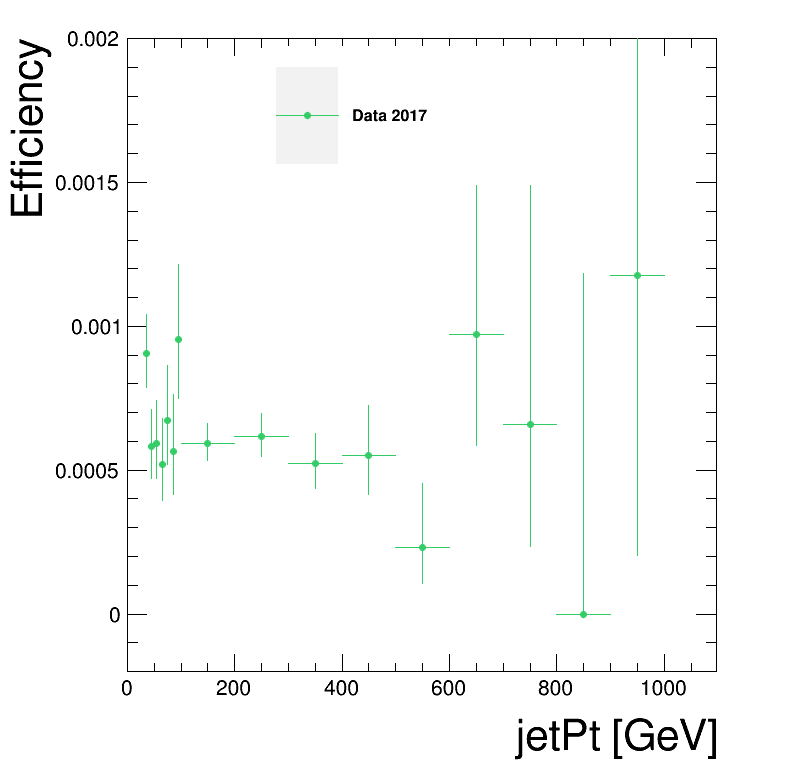

In [11]:

   

color_list = [845,800,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
    outf = 'tag_eff_jet_'+var[2]+'_rebin.png'
#     outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    # c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


In [32]:
variables = [
    
 
        ['jetPt [GeV]', pt_eta_pEff, 'pt', -0.0002, 0.01, 'jetEta', 'eta'],
        ['jetPt [GeV]', pt_phi_pEff, 'pt', -0.0002, 0.01, 'jetPhi', 'phi'],
        
]

var/x_axis jetPt [GeV] name pt range -0.0002 0.01
Data 2016 <TTree b'SusyLLPTree' at 0x7f32e01e30b8>
var/x_axis jetPt [GeV] name pt range -0.0002 0.01
Data 2016 <TTree b'SusyLLPTree' at 0x7f32e01e30b8>


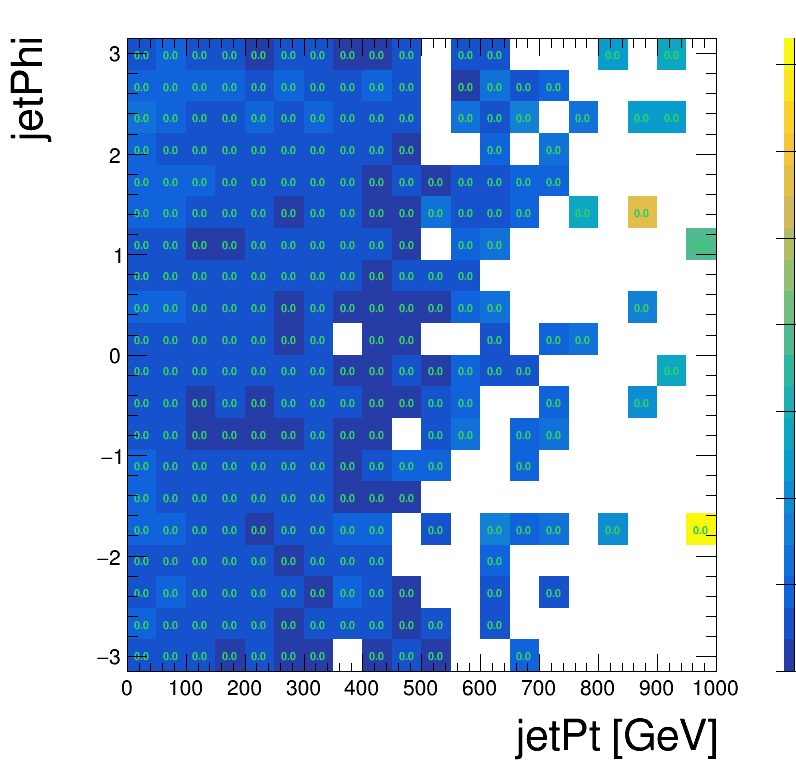

In [38]:

   

color_list = [845,800,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    outf = 'tag_eff_jet_'+var[2]+'_'+var[6]+'_2d.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
            pEff[k].SetTitle("efficiency;"+var[0]+";"+var[5]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("colztext")
            else:
                pEff[k].Draw("colzsame text")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
   
#             pEff[k].GetPaintedGraph().SetMinimum(var[3])
#             pEff[k].GetPaintedGraph().SetMaximum(var[4])
 
            pEff[k].GetPaintedHistogram().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedHistogram().GetYaxis().SetLabelSize(0.03)
#             pEff[k].GetPaintedHistogram().GetZaxis().SetLabelSize(0.03)

            i += 1

#             print('dim: ', pEff[k].GetDimension())
# #             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(100):
#                 print(cnt)
# #                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            leg.AddEntry(pEff[k],k)

#     leg.Draw()

    # c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


# Prediction Region

In [35]:
trg_path=310
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}


for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()

    weight = v['weight'].array()
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)
    
#   sel 
#     trg_jet_met[k] = met
#     trg_jet_nj[k] = nj 
#     trg_jet_w[k] = weight 
# #     trg_jet_mt[k] = mt
#     trg_jet_ht[k] = ht
#     trg_jet_mdphi[k] = mdphi
    
#     trg_jet_pt[k] = pt
#     trg_jet_eta[k] = eta
#     trg_jet_e[k] = e
#     trg_jet_phi[k] = phi
#     trg_jet_chef[k] = chef
#     trg_jet_nhef[k] = nhef
#     trg_jet_cemef[k] = cemef
#     trg_jet_nemef[k] = nemef
    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_pt[k]))

    

Data 2017 <TTree b'SusyLLPTree' at 0x7f6d6d378080>
(3438214,)
2386583
2386583


In [36]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/'+'Data/goodlumi_1pho_0lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/'+'Data/goodlumi_0lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
 
 
print(plotDir)
os.system("mkdir -p "+ plotDir)

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/Data/goodlumi_0lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/


0

In [37]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

Data 2017 <TTree b'SusyLLPTree' at 0x7f6d6d378080>
[[319.02103 38.096966] [435.88544 371.9999 240.39235] [273.88553 63.4606 37.26642] ... [161.09995] [446.80966] [205.14825]]
[[] [] [] ... [] [] []]
[[319.02103 38.096966] [435.88544 371.9999 240.39235] [273.88553 63.4606 37.26642] ... [161.09995] [446.80966] [205.14825]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14]
[0 1 2]
[0 1 2]


In [38]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Bin 0 Yield', 'Bin 0 Error', 'Bin 1 Yield', 'Bin 1 Error', 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
    if 'Data' in k:
        lumi=1
        sf=1
    elif 'QCD' in k:
        lumi=35900
        sf=1.2
    else:
        lumi=35900
        sf=1
    if 'Data' not in k:
        row = [k, round (sum(trg_jet_w[k][nTags[k]==0])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==0]))*lumi*sf, 2) , round (sum(trg_jet_w[k][nTags[k]==1])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==1]))*lumi*sf, 2) , round (sum(trg_jet_w[k][nTags[k]==2])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==2]))*lumi*sf, 2)  ]
    else:
        row = [k, round (sum(trg_jet_w[k][nTags[k]==0])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==0]))*lumi*sf, 2) , round (sum(trg_jet_w[k][nTags[k]==1])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==1]))*lumi*sf, 2) , 0.0 , 0.0  ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+-----------+-------------+-------------+-------------+-------------+-------------+-------------+
|   Sample  | Bin 0 Yield | Bin 0 Error | Bin 1 Yield | Bin 1 Error | Bin 2 Yield | Bin 2 Error |
+-----------+-------------+-------------+-------------+-------------+-------------+-------------+
| Data 2017 |  2384228.0  |   1544.09   |    2351.0   |    48.49    |     0.0     |     0.0     |
+-----------+-------------+-------------+-------------+-------------+-------------+-------------+


In [39]:
table_txt = table.get_string()
with open(plotDir+'/BeforePredictionSummaryTable.txt','w') as file:
    file.write(table_txt)

In [17]:
print(chr(177))

±


# Fake rate method

In [17]:
def GetEffWeight(pts, ws, peff):
    EffW=[]
    EffWUp=[]
    EffWLow=[]
    for evt in range(len(pts)):
        binN=peff.GetPassedHistogram().FindBin(pts[evt])
        
        eff=peff.GetEfficiency(binN)
        errUp=peff.GetEfficiencyErrorUp(binN)
        errLow=peff.GetEfficiencyErrorLow(binN)
        
        effUp=eff+errUp
        effLow=eff-errLow
        
        effW=ws[evt]*eff
        effWUp=ws[evt]*effUp
        effWLow=ws[evt]*effLow
        
        EffW.append(effW)
        EffWUp.append(effWUp)
        EffWLow.append(effWLow)
        
    return EffW, EffWUp, EffWLow
        
        

In [18]:
# def GetEffWeightBin2(pts, ws, peff):
#     EffW=[]
#     EffWUp=[]
#     EffWLow=[]
#     evt=0
#     for evt in range(len(pts)):
#         cnt=0
#         p1=1
#         p1Up=1
#         p1Low=1
#         p0=1
#         p0Up=1
#         p0Low=1
#         for cnt in range(len(pts[evt])):
#             binN=peff.GetPassedHistogram().FindBin(pts[evt][cnt])
        
#             eff=peff.GetEfficiency(binN)
#             errUp=peff.GetEfficiencyErrorUp(binN)
#             errLow=peff.GetEfficiencyErrorLow(binN)
        
#             effUp=eff+errUp
#             effLow=eff-errLow
            
#             p1=p1*eff
#             p1Up=p1Up*effUp
#             p1Low=p1Low*effLow
            
#             p0=p0*(1-eff)
#             p0Up=p0Up*(1-effUp)
#             p0Low=p0Low*(1-effLow)
            
#         p2=1-p0-p1
#         p2Up=1-p0Up-p1Up
#         p2Low=1-p0Low-p1Low
        
#         effW=ws[evt]*p2
#         effWUp=ws[evt]*p2Up
#         effWLow=ws[evt]*p2Low
        
#         EffW.append(effW)
#         EffWUp.append(effWUp)
#         EffWLow.append(effWLow)
        
#     return EffW, EffWUp, EffWLow
        
        

In [18]:
def GetEffWeightBin2(pts, ws, peff):
    EffW=[]
    EffWUp=[]
    EffWLow=[]
    evt=0
    for evt in range(len(pts)):
        cnt=0
        p2=0
        p2Up=0
        p2Low=0
        for cnt in range(len(pts[evt])):
            binN=peff.GetPassedHistogram().FindBin(pts[evt][cnt])
        
            eff1=peff.GetEfficiency(binN)
            errUp1=peff.GetEfficiencyErrorUp(binN)
            errLow1=peff.GetEfficiencyErrorLow(binN)
        
            effUp1=eff1+errUp1
            effLow1=eff1-errLow1
            
            ct=0
            for ct in range(len(pts[evt])):
                
                binN=peff.GetPassedHistogram().FindBin(pts[evt][ct])

                eff2=peff.GetEfficiency(binN)
                errUp2=peff.GetEfficiencyErrorUp(binN)
                errLow2=peff.GetEfficiencyErrorLow(binN)

                effUp2=eff2+errUp2
                effLow2=eff2-errLow2
            
                if ct>cnt:
                    p2=p2+eff1*eff2
                    p2Up=p2Up+effUp1*effUp2
                    p2Low=p2Low+effLow1*effLow2

        effW=ws[evt]*p2
        effWUp=ws[evt]*p2Up
        effWLow=ws[evt]*p2Low
        
        EffW.append(effW)
        EffWUp.append(effWUp)
        EffWLow.append(effWLow)
        
    return EffW, EffWUp, EffWLow
        
        

In [19]:
def GetEffWeightBin1(pts, ws, peff):
    EffW=[]
    EffWUp=[]
    EffWLow=[]
    evt=0
    for evt in range(len(pts)):
        cnt=0
        p1=0
        p1Up=0
        p1Low=0
        for cnt in range(len(pts[evt])):
            binN=peff.GetPassedHistogram().FindBin(pts[evt][cnt])
        
            eff=peff.GetEfficiency(binN)
            errUp=peff.GetEfficiencyErrorUp(binN)
            errLow=peff.GetEfficiencyErrorLow(binN)
        
            effUp=eff+errUp
            effLow=eff-errLow
            
            p1=p1+eff
            p1Up=p1Up+effUp
            p1Low=p1Low+effLow
    
        effW=ws[evt]*p1
        effWUp=ws[evt]*p1Up
        effWLow=ws[evt]*p1Low
        
        EffW.append(effW)
        EffWUp.append(effWUp)
        EffWLow.append(effWLow)
        
    return EffW, EffWUp, EffWLow
        
        

In [20]:
def GetEffWeight2D(pts, etas, ws, peff):
    EffW=[]
    EffWUp=[]
    EffWLow=[]
    for evt in range(len(pts)):
        binN=peff.GetPassedHistogram().FindBin(pts[evt], etas[evt])
        
        eff=peff.GetEfficiency(binN)
        errUp=peff.GetEfficiencyErrorUp(binN)
        errLow=peff.GetEfficiencyErrorLow(binN)
        
        effUp=eff+errUp
        effLow=eff-errLow
        
        effW=ws[evt]*eff
        effWUp=ws[evt]*effUp
        effWLow=ws[evt]*effLow
        
        EffW.append(effW)
        EffWUp.append(effWUp)
        EffWLow.append(effWLow)
        
    return EffW, EffWUp, EffWLow
        
        

In [45]:
# jet_bool = {}

cr_nj_cut = 1
cr_ntag_cut = 0

cr_jet_pt={}
cr_jet_eta={}
cr_jet_phi={}
cr_jet_w={}
cr_jet_pts={}
cr_jet_etas={}
cr_jet_phis={}
cr_jet_ws={}

pt_pred_jet_ws={}
pt_pred_jet_ws_up={}
pt_pred_jet_ws_low={}

eta_pred_jet_ws={}
eta_pred_jet_ws_up={}
eta_pred_jet_ws_low={}

phi_pred_jet_ws={}
phi_pred_jet_ws_up={}
phi_pred_jet_ws_low={}

pt_eta_pred_jet_ws={}
pt_eta_pred_jet_ws_up={}
pt_eta_pred_jet_ws_low={}

pt_phi_pred_jet_ws={}
pt_phi_pred_jet_ws_up={}
pt_phi_pred_jet_ws_low={}

for k,v in tree.items():
    print(k,v)
            
#     jet_bool[k] = tagged_jet
    
#     print(jet_bool[k][:10])
    
    cr_cut_str=np.logical_and(nJets[k]>=cr_nj_cut, nTags[k]==cr_ntag_cut)
    
    cr_jet_pt[k] = trg_jet_pt[k][cr_cut_str]
    cr_jet_eta[k] = trg_jet_eta[k][cr_cut_str]
    cr_jet_phi[k] = trg_jet_phi[k][cr_cut_str]
    cr_jet_w[k] = trg_jet_w[k][cr_cut_str]
    
    # to bin1
    cr_jet_pts[k] = cr_jet_pt[k].flatten()
    cr_jet_etas[k] = cr_jet_eta[k].flatten()
    cr_jet_phis[k] = cr_jet_phi[k].flatten()
    cr_jet_ws[k] = [np.array([x]*len(y)) for x,y in zip(cr_jet_w[k],cr_jet_pt[k])]
    cr_jet_ws[k] = list(chain.from_iterable(cr_jet_ws[k])) 
    
    print(len(cr_jet_pt[k]))
    print(len(cr_jet_w[k]))
    
    print(len(cr_jet_pts[k]))
    print(len(cr_jet_ws[k]))
    
    #1d 
    pt_pred_jet_ws[k], pt_pred_jet_ws_up[k], pt_pred_jet_ws_low[k]  = GetEffWeight(cr_jet_pts[k], cr_jet_ws[k], pt_pEff[k])
    
    # to bin2
#     pt_pred_jet_ws[k], pt_pred_jet_ws_up[k], pt_pred_jet_ws_low[k]  = GetEffWeightBin1(cr_jet_pt[k], cr_jet_w[k], pt_pEff[k])
#     pt_pred_jet_ws[k], pt_pred_jet_ws_up[k], pt_pred_jet_ws_low[k]  = GetEffWeightBin2(cr_jet_pt[k], cr_jet_w[k], pt_pEff[k])
    
#     eta_pred_jet_ws[k], eta_pred_jet_ws_up[k], eta_pred_jet_ws_low[k]  = GetEffWeight(cr_jet_etas[k], cr_jet_ws[k], eta_pEff[k])
#     phi_pred_jet_ws[k], phi_pred_jet_ws_up[k], phi_pred_jet_ws_low[k]  = GetEffWeight(cr_jet_phis[k], cr_jet_ws[k], phi_pEff[k])
#     #2d
#     pt_eta_pred_jet_ws[k], pt_eta_pred_jet_ws_up[k], pt_eta_pred_jet_ws_low[k]  = GetEffWeight2D(cr_jet_pts[k], cr_jet_etas[k], cr_jet_ws[k], pt_eta_pEff[k])
#     pt_phi_pred_jet_ws[k], pt_phi_pred_jet_ws_up[k], pt_phi_pred_jet_ws_low[k]  = GetEffWeight2D(cr_jet_pts[k], cr_jet_phis[k], cr_jet_ws[k], pt_phi_pEff[k])
    
#     print(len(pred_jet_ws[k]))
    
 
    

Data 2017 <TTree b'SusyLLPTree' at 0x7f6d6d378080>
1616649
1616649
3007572
3007572


In [46]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'method', 'Bin 1 Prediction', 'Bin 1 Prediction Error Up', 'Bin 1 Prediction Error Low'])
# table =  PrettyTable(['Sample', 'method', 'Bin 2 Prediction', 'Bin 2 Prediction Error Up', 'Bin 2 Prediction Error Low'])
for k,v in tree.items():
    if 'Data' in k:
        lumi=1
        sf=1
    elif 'QCD' in k:
        lumi=35900
        sf=1.1
    else:
        lumi=35900
        sf=1
    row = [k, '1D pt', round (sum(pt_pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(pt_pred_jet_ws_up[k])-sum(pt_pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(pt_pred_jet_ws_low[k])-sum(pt_pred_jet_ws[k]))*lumi*sf  , 2)]
    table.add_row(row)
#     row = [k, '1D eta', round (sum(eta_pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(eta_pred_jet_ws_up[k])-sum(eta_pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(eta_pred_jet_ws_low[k])-sum(eta_pred_jet_ws[k]))*lumi*sf  , 2)]
#     table.add_row(row)
#     row = [k, '1D phi', round (sum(phi_pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(phi_pred_jet_ws_up[k])-sum(phi_pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(phi_pred_jet_ws_low[k])-sum(phi_pred_jet_ws[k]))*lumi*sf  , 2)]
#     table.add_row(row)
#     row = [k, '2D pt eta', round (sum(pt_eta_pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(pt_eta_pred_jet_ws_up[k])-sum(pt_eta_pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(pt_eta_pred_jet_ws_low[k])-sum(pt_eta_pred_jet_ws[k]))*lumi*sf  , 2)]
#     table.add_row(row)
#     row = [k, '2D pt phi', round (sum(pt_phi_pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(pt_phi_pred_jet_ws_up[k])-sum(pt_phi_pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(pt_phi_pred_jet_ws_low[k])-sum(pt_phi_pred_jet_ws[k]))*lumi*sf  , 2)]
#     table.add_row(row)
        
print(table)



======================= Summary ==============================
+-----------+--------+------------------+---------------------------+----------------------------+
|   Sample  | method | Bin 1 Prediction | Bin 1 Prediction Error Up | Bin 1 Prediction Error Low |
+-----------+--------+------------------+---------------------------+----------------------------+
| Data 2017 | 1D pt  |     1884.49      |           494.12          |           329.04           |
+-----------+--------+------------------+---------------------------+----------------------------+


In [42]:
table_txt = table.get_string()
# with open(plotDir+'/PredictionSummaryTableBin2Rebin.txt','w') as file:
with open(plotDir+'/PredictionSummaryTableBin1Rebin.txt','w') as file:
# with open(plotDir+'/PredictionSummaryTableBin1.txt','w') as file:
# with open(plotDir+'/PredictionSummaryTableBin2.txt','w') as file:
    file.write(table_txt)

In [50]:
# jet_bool = {}

cr_nj_cut = 2
cr_ntag_cut = 0

cr_jet_pt={}
cr_jet_eta={}
cr_jet_phi={}
cr_jet_w={}
cr_jet_pts={}
cr_jet_etas={}
cr_jet_phis={}
cr_jet_ws={}

pt_pred_jet_ws={}
pt_pred_jet_ws_up={}
pt_pred_jet_ws_low={}

eta_pred_jet_ws={}
eta_pred_jet_ws_up={}
eta_pred_jet_ws_low={}

phi_pred_jet_ws={}
phi_pred_jet_ws_up={}
phi_pred_jet_ws_low={}

pt_eta_pred_jet_ws={}
pt_eta_pred_jet_ws_up={}
pt_eta_pred_jet_ws_low={}

pt_phi_pred_jet_ws={}
pt_phi_pred_jet_ws_up={}
pt_phi_pred_jet_ws_low={}

for k,v in tree.items():
    print(k,v)
            
#     jet_bool[k] = tagged_jet
    
#     print(jet_bool[k][:10])
    
    cr_cut_str=np.logical_and(nJets[k]>=cr_nj_cut, nTags[k]==cr_ntag_cut)
    
    cr_jet_pt[k] = trg_jet_pt[k][cr_cut_str]
    cr_jet_eta[k] = trg_jet_eta[k][cr_cut_str]
    cr_jet_phi[k] = trg_jet_phi[k][cr_cut_str]
    cr_jet_w[k] = trg_jet_w[k][cr_cut_str]
    
    # to bin1
    cr_jet_pts[k] = cr_jet_pt[k].flatten()
    cr_jet_etas[k] = cr_jet_eta[k].flatten()
    cr_jet_phis[k] = cr_jet_phi[k].flatten()
    cr_jet_ws[k] = [np.array([x]*len(y)) for x,y in zip(cr_jet_w[k],cr_jet_pt[k])]
    cr_jet_ws[k] = list(chain.from_iterable(cr_jet_ws[k])) 
    
    print(len(cr_jet_pt[k]))
    print(len(cr_jet_w[k]))
    
    print(len(cr_jet_pts[k]))
    print(len(cr_jet_ws[k]))
    
    #1d 
#     pt_pred_jet_ws[k], pt_pred_jet_ws_up[k], pt_pred_jet_ws_low[k]  = GetEffWeight(cr_jet_pts[k], cr_jet_ws[k], pt_pEff[k])
    
    # to bin2
#     pt_pred_jet_ws[k], pt_pred_jet_ws_up[k], pt_pred_jet_ws_low[k]  = GetEffWeightBin1(cr_jet_pt[k], cr_jet_w[k], pt_pEff[k])
    pt_pred_jet_ws[k], pt_pred_jet_ws_up[k], pt_pred_jet_ws_low[k]  = GetEffWeightBin2(cr_jet_pt[k], cr_jet_w[k], pt_pEff[k])
    
#     eta_pred_jet_ws[k], eta_pred_jet_ws_up[k], eta_pred_jet_ws_low[k]  = GetEffWeight(cr_jet_etas[k], cr_jet_ws[k], eta_pEff[k])
#     phi_pred_jet_ws[k], phi_pred_jet_ws_up[k], phi_pred_jet_ws_low[k]  = GetEffWeight(cr_jet_phis[k], cr_jet_ws[k], phi_pEff[k])
#     #2d
#     pt_eta_pred_jet_ws[k], pt_eta_pred_jet_ws_up[k], pt_eta_pred_jet_ws_low[k]  = GetEffWeight2D(cr_jet_pts[k], cr_jet_etas[k], cr_jet_ws[k], pt_eta_pEff[k])
#     pt_phi_pred_jet_ws[k], pt_phi_pred_jet_ws_up[k], pt_phi_pred_jet_ws_low[k]  = GetEffWeight2D(cr_jet_pts[k], cr_jet_phis[k], cr_jet_ws[k], pt_phi_pEff[k])
    
#     print(len(pred_jet_ws[k]))
    
 
    

Data 2017 <TTree b'SusyLLPTree' at 0x7f6d6d378080>
837230
837230
2228153
2228153


In [51]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
# table =  PrettyTable(['Sample', 'method', 'Bin 1 Prediction', 'Bin 1 Prediction Error Up', 'Bin 1 Prediction Error Low'])
table =  PrettyTable(['Sample', 'method', 'Bin 2 Prediction', 'Bin 2 Prediction Error Up', 'Bin 2 Prediction Error Low'])
for k,v in tree.items():
    if 'Data' in k:
        lumi=1
        sf=1
    elif 'QCD' in k:
        lumi=35900
        sf=1.1
    else:
        lumi=35900
        sf=1
    row = [k, '1D pt', round (sum(pt_pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(pt_pred_jet_ws_up[k])-sum(pt_pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(pt_pred_jet_ws_low[k])-sum(pt_pred_jet_ws[k]))*lumi*sf  , 2)]
    table.add_row(row)
#     row = [k, '1D eta', round (sum(eta_pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(eta_pred_jet_ws_up[k])-sum(eta_pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(eta_pred_jet_ws_low[k])-sum(eta_pred_jet_ws[k]))*lumi*sf  , 2)]
#     table.add_row(row)
#     row = [k, '1D phi', round (sum(phi_pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(phi_pred_jet_ws_up[k])-sum(phi_pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(phi_pred_jet_ws_low[k])-sum(phi_pred_jet_ws[k]))*lumi*sf  , 2)]
#     table.add_row(row)
#     row = [k, '2D pt eta', round (sum(pt_eta_pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(pt_eta_pred_jet_ws_up[k])-sum(pt_eta_pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(pt_eta_pred_jet_ws_low[k])-sum(pt_eta_pred_jet_ws[k]))*lumi*sf  , 2)]
#     table.add_row(row)
#     row = [k, '2D pt phi', round (sum(pt_phi_pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(pt_phi_pred_jet_ws_up[k])-sum(pt_phi_pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(pt_phi_pred_jet_ws_low[k])-sum(pt_phi_pred_jet_ws[k]))*lumi*sf  , 2)]
#     table.add_row(row)
        
print(table)



======================= Summary ==============================
+-----------+--------+------------------+---------------------------+----------------------------+
|   Sample  | method | Bin 2 Prediction | Bin 2 Prediction Error Up | Bin 2 Prediction Error Low |
+-----------+--------+------------------+---------------------------+----------------------------+
| Data 2017 | 1D pt  |       0.88       |            0.61           |            0.29            |
+-----------+--------+------------------+---------------------------+----------------------------+


In [52]:
table_txt = table.get_string()
with open(plotDir+'/PredictionSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/PredictionSummaryTableBin1Rebin.txt','w') as file:
# with open(plotDir+'/PredictionSummaryTableBin1.txt','w') as file:
# with open(plotDir+'/PredictionSummaryTableBin2.txt','w') as file:
    file.write(table_txt)

# Check plots

In [43]:
variables = [
 
        ['minDeltaPhi', trg_jet_mdphi, 50, 0, 3.15],
        ['HT', trg_jet_ht, 40, 0, 2000],
        ['MET', trg_jet_met, 20, 0, 2000],
        ['nJets', nJets, 20, 0, 20],
#         ['nJets', trg_jet_nj, 20, 0, 20],
    
]

var/x_axis minDeltaPhi binning 50 0 3.15
2386583
1616649
2351
0
Prediction
1616649
1
1 tag
2351
35.9 fb^{-1} (13 TeV)
var/x_axis HT binning 40 0 2000
2386583
1616649
2351
0
Prediction
1616649
1
1 tag
2351
35.9 fb^{-1} (13 TeV)
var/x_axis MET binning 20 0 2000
2386583
1616649
2351
0
Prediction
1616649
1
1 tag
2351
35.9 fb^{-1} (13 TeV)
var/x_axis nJets binning 20 0 20
2386583
1616649
2351
0
Prediction
1616649
1
1 tag
2351
35.9 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/Data/goodlumi_0lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/minDeltaPhi_vs_pred.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/Data/goodlumi_0lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/HT_vs_pred.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/Data/goodlumi_0lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/MET_vs_pred.png has been created
Warning in <TCanvas::Construct

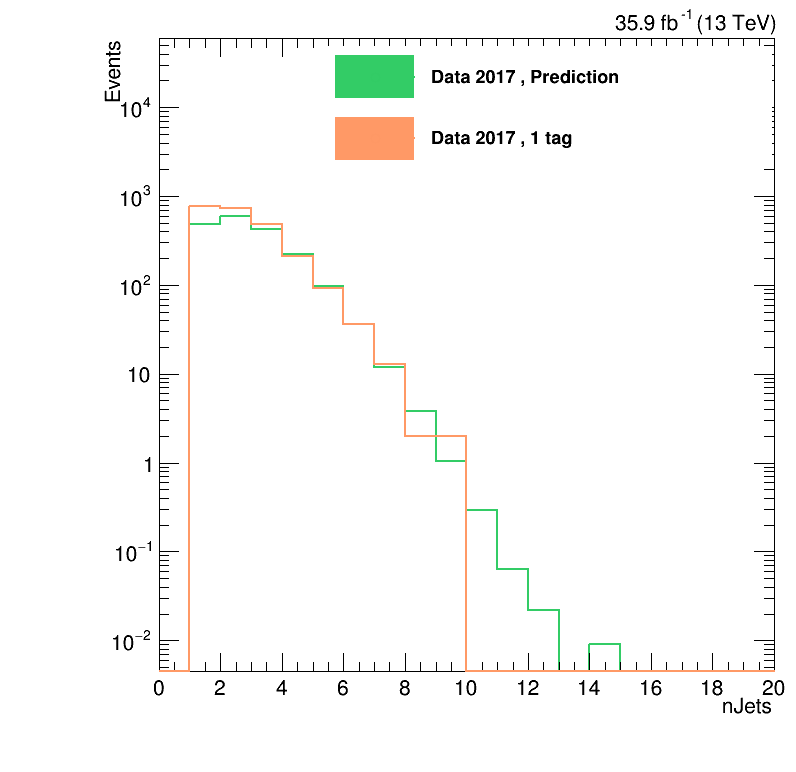

In [44]:
cr_nj_cut = 1
cr_ntag_cut = 0

sr_nj_cut = 1
sr_ntag_cut = 1


for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
 
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    lumi = 35900 
    outf = var[0]+'_vs_pred.png'
    
    # Plotting  
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    he = {}
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
  
    color_list = [845,806,861,876,597,625]
#     color_list = [845,800,861,806,876,597,625]
 
    data_keys = ['Data 2017']
   
   
    for k in data_keys:
        cr_cut_str=np.logical_and(nJets[k]>=cr_nj_cut, nTags[k]==cr_ntag_cut)
        sr_cut_str=np.logical_and(nJets[k]>=sr_nj_cut, nTags[k]==sr_ntag_cut)
        print(len(var[1][k]))
        print(len(var[1][k][cr_cut_str]))
        print(len(var[1][k][sr_cut_str]))
        i=0
        for i in range(2):
            print(i)
            if i!=0:
                sel_str=sr_cut_str
                leg_str='1 tag'
                w = trg_jet_w[k][sel_str] 
            else:
                sel_str=cr_cut_str
                leg_str='Prediction'
                w = pt_pred_jet_ws[k] 
                
            pt1 = var[1][k] 
            v = pt1[sel_str] 
#             w = trg_jet_w[k][sel_str] 
            
            print(leg_str)
            print(len(w))

            ht[k+leg_str] = create_TH1D( v, axis_title=axis_set, name=k+leg_str, binning=bin_set,weights = w*1)
            ht[k+leg_str].Sumw2()
            ht[k+leg_str].SetLineColor(color_list[i])
            ht[k+leg_str].SetMarkerColor(color_list[i])
            ht[k+leg_str].SetMarkerStyle(20)
            ht[k+leg_str].SetMarkerSize(1.)
            ht[k+leg_str].GetXaxis().SetTitleSize(0.03)
            ht[k+leg_str].GetYaxis().SetTitleSize(0.03)
            ht[k+leg_str].GetXaxis().SetLabelSize(0.03)
            ht[k+leg_str].GetYaxis().SetLabelSize(0.03)
            ht[k+leg_str].SetMaximum(1e+2*(ht[k+leg_str].GetMaximum()))
            ht[k+leg_str].Draw("Hist same")

            he[k+leg_str] = ht[k+leg_str].Clone()
            he[k+leg_str].SetFillColor(color_list[i])
#             he[k+leg_str].Draw("e2 same")

            leg.AddEntry(he[k+leg_str],k+' , '+leg_str)
#         leg.AddEntry(ht[k],k+' '+str(lumi/1000)+' /fb')

#         i+=1

    leg.Draw()

  

    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

In [47]:
cr_nj_cut = 1
cr_ntag_cut = 0

sr_nj_cut = 1
sr_ntag_cut = 1


for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
 
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    lumi = 35900 
    outf = var[0]+'_vs_pred_shape.png'
    
    # Plotting  
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    he = {}
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
  
    color_list = [845,806,861,876,597,625]
#     color_list = [845,800,861,806,876,597,625]
 
    data_keys = ['Data 2016']
   
   
    for k in data_keys:
        cr_cut_str=np.logical_and(nJets[k]>=cr_nj_cut, nTags[k]==cr_ntag_cut)
        sr_cut_str=np.logical_and(nJets[k]>=sr_nj_cut, nTags[k]==sr_ntag_cut)
        print(len(var[1][k]))
        print(len(var[1][k][cr_cut_str]))
        print(len(var[1][k][sr_cut_str]))
        i=0
        for i in range(2):
            print(i)
            if i!=0:
                sel_str=sr_cut_str
                leg_str='1 tag'
            else:
                sel_str=cr_cut_str
                leg_str='Prediction'
                
            pt1 = var[1][k] 
            v = pt1[sel_str] 
            w = trg_jet_w[k][sel_str] 
            
            print(leg_str)
            print(len(w))

            ht[k+leg_str] = create_TH1D( v, axis_title=axis_set, name=k+leg_str, binning=bin_set,weights = w*1)
            ht[k+leg_str].Sumw2()
            ht[k+leg_str].SetLineColor(color_list[i])
            ht[k+leg_str].SetMarkerColor(color_list[i])
            ht[k+leg_str].SetMarkerStyle(20)
            ht[k+leg_str].SetMarkerSize(1.)
            ht[k+leg_str].GetXaxis().SetTitleSize(0.03)
            ht[k+leg_str].GetYaxis().SetTitleSize(0.03)
            ht[k+leg_str].GetXaxis().SetLabelSize(0.03)
            ht[k+leg_str].GetYaxis().SetLabelSize(0.03)
            ht[k+leg_str].SetMaximum(1e+3*(ht[k+leg_str].GetMaximum()))
            ht[k+leg_str].DrawNormalized("Hist same")

            he[k+leg_str] = ht[k+leg_str].Clone()
            he[k+leg_str].SetFillColor(color_list[i])
#             he[k+leg_str].Draw("e2 same")

            leg.AddEntry(he[k+leg_str],k+' , '+leg_str)
#         leg.AddEntry(ht[k],k+' '+str(lumi/1000)+' /fb')

#         i+=1

    leg.Draw()

  

    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

var/x_axis minDeltaPhi binning 50 0 3.15


KeyError: 'Data 2016'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [48]:
variables = [
    
        ['jetTime', tag_jet_time, 50, -13, 13, trg_jet_time],
        ['jetMinDeltaRPVTracks', tag_jet_dr, 50, 0, 3, trg_jet_dr],
        ['jetTMF', tag_jet_tmf, 50, 0, 1, trg_jet_tmf,],
    
    
        ['jetPt', tag_jet_pt, 20, 0, 2000,  trg_jet_pt],
        ['jetEta', tag_jet_eta, 20, -3.15, 3.15, trg_jet_eta,],
        ['jetE', tag_jet_e, 50, 0, 1000, trg_jet_e,],
        ['jetPhi', tag_jet_phi, 20, -3.15, 3.15, trg_jet_phi],
    
     
        ['jetMuonEnergyFraction', tag_jet_muef, 50, 0, 1, trg_jet_muef],
        ['jetElectronEnergyFraction', tag_jet_eleef, 50, 0, 1, trg_jet_eleef],
        ['jetPhotonEnergyFraction', tag_jet_phoef, 50, 0, 1, trg_jet_phoef],
    
        ['jetChargedHadronEnergyFraction', tag_jet_chef, 50, 0, 1, trg_jet_chef],
    
 
#         ['jetPt', tag_jet_pt, 20, 0, 2000,  cr_jet_pts],
    
    
]

var/x_axis jetTime binning 50 -13 13
2386583
1616649
2351
0
Prediction
3007572
3007572
1
1 tag
2351
2351
35.9 fb^{-1} (13 TeV)
var/x_axis jetMinDeltaRPVTracks binning 50 0 3
2386583
1616649
2351
0
Prediction
3007572
3007572
1
1 tag
2351
2351
35.9 fb^{-1} (13 TeV)
var/x_axis jetTMF binning 50 0 1
2386583
1616649
2351
0
Prediction
3007572
3007572
1
1 tag
2351
2351
35.9 fb^{-1} (13 TeV)
var/x_axis jetPt binning 20 0 2000
2386583
1616649
2351
0
Prediction
3007572
3007572
1
1 tag
2351
2351
35.9 fb^{-1} (13 TeV)
var/x_axis jetEta binning 20 -3.15 3.15
2386583
1616649
2351
0
Prediction
3007572
3007572
1
1 tag
2351
2351
35.9 fb^{-1} (13 TeV)
var/x_axis jetE binning 50 0 1000
2386583
1616649
2351
0
Prediction
3007572
3007572
1
1 tag
2351
2351
35.9 fb^{-1} (13 TeV)
var/x_axis jetPhi binning 20 -3.15 3.15
2386583
1616649
2351
0
Prediction
3007572
3007572
1
1 tag
2351
2351
35.9 fb^{-1} (13 TeV)
var/x_axis jetMuonEnergyFraction binning 50 0 1
2386583
1616649
2351
0
Prediction
3007572
3007572
1
1 ta

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/Data/goodlumi_0lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/jetTime_vs_pred.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/Data/goodlumi_0lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/jetMinDeltaRPVTracks_vs_pred.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/Data/goodlumi_0lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/jetTMF_vs_pred.png has been created
Warning in <T

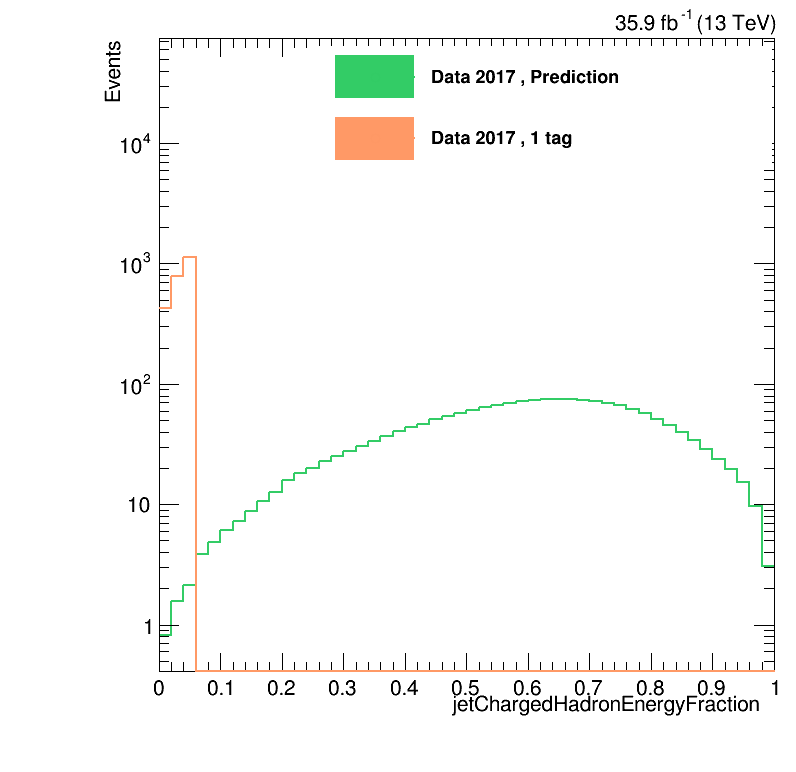

In [49]:
cr_nj_cut = 1
cr_ntag_cut = 0

sr_nj_cut = 1
sr_ntag_cut = 1


for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
 
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    lumi = 35900 
    outf = var[0]+'_vs_pred.png'
    
    # Plotting  
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    he = {}
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
  
    color_list = [845,806,861,876,597,625]
#     color_list = [845,800,861,806,876,597,625]
 
    data_keys = ['Data 2017']
   
   
    for k in data_keys:
        cr_cut_str=np.logical_and(nJets[k]>=cr_nj_cut, nTags[k]==cr_ntag_cut)
        sr_cut_str=np.logical_and(nJets[k]>=sr_nj_cut, nTags[k]==sr_ntag_cut)
        print(len(var[1][k]))
        print(len(var[1][k][cr_cut_str]))
        print(len(var[1][k][sr_cut_str]))
        i=0
        for i in range(2):
            print(i)
            if i!=0:
                sel_str=sr_cut_str
                leg_str='1 tag'
                pt1 = var[1][k] 
                v = pt1[sel_str] 
                w = trg_jet_w[k][sel_str] 
            else:
                sel_str=cr_cut_str
                leg_str='Prediction'
                # var[5] = trg_jet_pt
                pt1 = var[5][k][sel_str]
                v = pt1.flatten()
                # var[5] = cr_jrt_pts
#                 pt1 = var[5][k] 
#                 v = pt1 
                w = pt_pred_jet_ws[k]
#                 w = pred_jet_ws[k]
                
 
            
            print(leg_str)
            print(len(w))
            print(len(v))

            ht[k+leg_str] = create_TH1D( v, axis_title=axis_set, name=k+leg_str, binning=bin_set,weights = w*1)
            ht[k+leg_str].Sumw2()
            ht[k+leg_str].SetLineColor(color_list[i])
            ht[k+leg_str].SetMarkerColor(color_list[i])
            ht[k+leg_str].SetMarkerStyle(20)
            ht[k+leg_str].SetMarkerSize(1.)
            ht[k+leg_str].GetXaxis().SetTitleSize(0.03)
            ht[k+leg_str].GetYaxis().SetTitleSize(0.03)
            ht[k+leg_str].GetXaxis().SetLabelSize(0.03)
            ht[k+leg_str].GetYaxis().SetLabelSize(0.03)
            ht[k+leg_str].SetMaximum(1e+3*(ht[k+leg_str].GetMaximum()))
            ht[k+leg_str].Draw("Hist same")

            he[k+leg_str] = ht[k+leg_str].Clone()
            he[k+leg_str].SetFillColor(color_list[i])
#             he[k+leg_str].Draw("e2 same")

            leg.AddEntry(he[k+leg_str],k+' , '+leg_str)
#         leg.AddEntry(ht[k],k+' '+str(lumi/1000)+' /fb')

#         i+=1

    leg.Draw()

  

    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)
 